# WGAN-GP

## Importing necessary Libraries

In [75]:
!pip install tqdm
!pip install lpips

In [76]:
import os
import lpips
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision.transforms import ToPILImage

from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr

## Generator architecture

In [77]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()

        self.net = nn.Sequential(

            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.net(x)

## Discriminator architecture

In [78]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 4, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [79]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

## Gradient penalty

In [80]:
def get_gradient_penalty(disc, real_images, gen_images, lambda_gp=10):
    batch_size = real_images.size(0)
    epsilon = torch.rand(batch_size, 1, 1, 1, device=device).expand_as(real_images)
    interpolated = epsilon * real_images + (1 - epsilon) * fake_images
    interpolated.requires_grad_(True)

    d_interpolated = disc(interpolated)
    gradients = torch.autograd.grad(
        outputs = d_interpolated,
        inputs = interpolated,
        grad_outputs = torch.ones_like(d_interpolated, device=device),
        create_graph = True,
        retain_graph = True,
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp
    return gradient_penalty

## Setting the device and defining the parameters

In [81]:
# To ensure reproducibility, use a random seed.
torch.manual_seed(42)
np.random.seed(42)

# Check that GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
BATCH_SIZE = 64
Z_DIM = 100
IMAGE_SIZE = 64
CHANNELS_IMG = 3
LEARNING_RATE = 1e-4
FEATURES_CRITIC = 64
FEATURES_GEN = 64
EPOCHS_NUM = 1000
LAMBDA_GP = 10
CRITICS_NUM = 4  # Each generator update's number of discriminator updates

## Load the CIFAR10 dataset

In [82]:
transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

## Displaying Model Architechture after initialization

In [83]:
# Initialize the models here
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(disc)

# Architectures for display models
print("Generator Architecture:\n", gen)
print("\nDiscriminator Architecture:\n", disc)

# Initialize optimizers
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

Generator Architecture:
 Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, af

In [84]:
# Start the loss tracking lists.
wass_dist = []
gp_losses = []
disc_losses = []
gen_losses = []

## Training Loop

In [85]:
# Paths
generator_path = "generator_final.pth"
discriminator_path = "discriminator_final.pth"
checkpoint_path = "checkpoint.pth"

# Initialize starting epoch
start_epoch = 0

# Try loading models and checkpoint if available
if os.path.exists(generator_path) and os.path.exists(discriminator_path) and os.path.exists(checkpoint_path):
    print("Loading saved models and checkpoint...")

    gen.load_state_dict(torch.load(generator_path))
    disc.load_state_dict(torch.load(discriminator_path))

    checkpoint = torch.load(checkpoint_path)
    opt_gen.load_state_dict(checkpoint['opt_gen_state_dict'])
    opt_disc.load_state_dict(checkpoint['opt_disc_state_dict'])
    start_epoch = checkpoint['epoch'] + 1

    gen.train()
    disc.train()

    print(f"Resumed from epoch {start_epoch}")
else:
    print("No saved models found, starting from scratch.")

# Make sure sample directory exists
os.makedirs("samples", exist_ok=True)

# Training loop
for epoch in range(start_epoch, EPOCHS_NUM):
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{EPOCHS_NUM}")

    # Monitoring running losses
    total_wass_dist = 0.0
    total_gp = 0.0
    total_d_loss = 0.0
    total_g_loss = 0.0

    for i, (real_images, _) in progress_bar:
        real_images = real_images.to(device)
        cur_batch_size = real_images.shape[0]

        # Train Discriminator
        noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
        fake_images = gen(noise)

        real_outputs = disc(real_images).reshape(-1)
        fake_outputs = disc(fake_images).reshape(-1)

        wass_distance = fake_outputs.mean() - real_outputs.mean()
        gp_loss = get_gradient_penalty(disc, real_images, fake_images, LAMBDA_GP)

        d_loss = wass_distance + gp_loss

        opt_disc.zero_grad()
        d_loss.backward()
        opt_disc.step()

        total_wass_dist += wass_distance.item()
        total_gp += gp_loss.item()
        total_d_loss += d_loss.item()

        # Train Generator every CRITICS_NUM steps
        if i % CRITICS_NUM == 0:
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake_images = gen(noise)

            g_loss = -disc(fake_images).mean()
            opt_gen.zero_grad()
            g_loss.backward()
            opt_gen.step()

            total_g_loss += g_loss.item()

    # Average losses
    avg_wass_dist = total_wass_dist / len(train_loader)
    avg_gp = total_gp / len(train_loader)
    avg_d_loss = total_d_loss / len(train_loader)
    avg_g_loss = total_g_loss / (len(train_loader) / CRITICS_NUM)

    wass_dist.append(avg_wass_dist)
    gp_losses.append(avg_gp)
    disc_losses.append(avg_d_loss)
    gen_losses.append(avg_g_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS_NUM}] - Wasserstein: {avg_wass_dist:.4f}, GP: {avg_gp:.4f}, D_loss: {avg_d_loss:.4f}, G_loss: {avg_g_loss:.4f}")

    # Save sample generated images every 5 epochs
    if (epoch + 1) % 100 == 0 or epoch == 0:
        with torch.no_grad():
            noise = torch.randn(64, Z_DIM, 1, 1).to(device)
            fake_images = gen(noise)
            fake_images = (fake_images + 1) / 2  # Rescale from [-1,1] to [0,1]
            save_image(fake_images, f"samples/epoch_{epoch+1}.png", nrow=8, normalize=True)

    # Save models and checkpoint after every epoch
    torch.save(gen.state_dict(), generator_path)
    torch.save(disc.state_dict(), discriminator_path)
    torch.save({
        'epoch': epoch,
        'opt_gen_state_dict': opt_gen.state_dict(),
        'opt_disc_state_dict': opt_disc.state_dict(),
    }, checkpoint_path)

Loading saved models and checkpoint...
Resumed from epoch 1000


In [86]:
# genrator_path = "generator.pth"
# discriminator_path = "discriminator.pth"

# # Try loading pre-trained models if available
# if os.path.exists(generator_path):
#     gen.load_state_dict(torch.load(generator_path))
#     gen.eval()
#     print(f"Loaded generator from {generator_path}")
# else:
#     print(f"No saved generator found, starting from scratch.")

# if os.path.exists(discriminator_path):
#     disc.load_state_dict(torch.load(discriminator_path))
#     disc.eval()
#     print(f"Loaded discriminator from {discriminator_path}")
# else:
#     print(f"No saved discriminator found, starting from scratch.")

# for epoch in range(EPOCHS_NUM):
#     progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{EPOCHS_NUM}")

#     # Monitoring running losses for future averaging
#     total_wass_dist = 0.0
#     total_gp = 0.0
#     total_d_loss = 0.0
#     total_g_loss = 0.0

#     for i, (real_images, _) in progress_bar:
#         real_images = real_images.to(device)
#         cur_batch_size = real_images.shape[0]

#         # Train Discriminator
#         # Generate fake images
#         noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
#         fake_images = gen(noise)

#         # Compute Discriminator outputs
#         real_outputs = disc(real_images).reshape(-1)
#         fake_outputs = disc(fake_images).reshape(-1)

#         # Compute Gradient Penalty and Wasserstein distance
#         wass_distance = fake_outputs.mean() - real_outputs.mean()
#         gp_loss = get_gradient_penalty(disc, real_images, fake_images, LAMBDA_GP)

#         d_loss = wass_distance + gp_loss

#         opt_disc.zero_grad()

#         d_loss.backward()
#         opt_disc.step()

#         total_wass_dist += wass_distance.item()
#         total_gp += gp_loss.item()
#         total_d_loss += d_loss.item()

#         # Train Generator every CRITICS_NUM steps
#         if i % CRITICS_NUM == 0:
#             noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
#             fake_images = gen(noise)

#             g_loss = -disc(fake_images).mean()  # Maximize Discriminator fooling
#             opt_gen.zero_grad()
#             g_loss.backward()
#             opt_gen.step()

#             total_g_loss += g_loss.item()

#     # Average loss for epoch
#     avg_wass_dist = total_wass_dist / len(train_loader)
#     avg_gp = total_gp / len(train_loader)
#     avg_d_loss = total_d_loss / len(train_loader)
#     avg_g_loss = total_g_loss / (len(train_loader) / CRITICS_NUM)

#     wass_dist.append(avg_wass_dist)
#     gp_losses.append(avg_gp)
#     disc_losses.append(avg_d_loss)
#     gen_losses.append(avg_g_loss)

#     print(f"Epoch [{epoch+1}/{EPOCHS_NUM}] - "
#           f"Wasserstein: {avg_wass_dist:.4f}, "
#           f"GP: {avg_gp:.4f}, "
#           f"D_loss: {avg_d_loss:.4f}, "
#           f"G_loss: {avg_g_loss:.4f}")

# # Save models
# torch.save(G.state_dict(), genrator_path)
# torch.save(D.state_dict(), discriminator_path)


# Plot training curves here

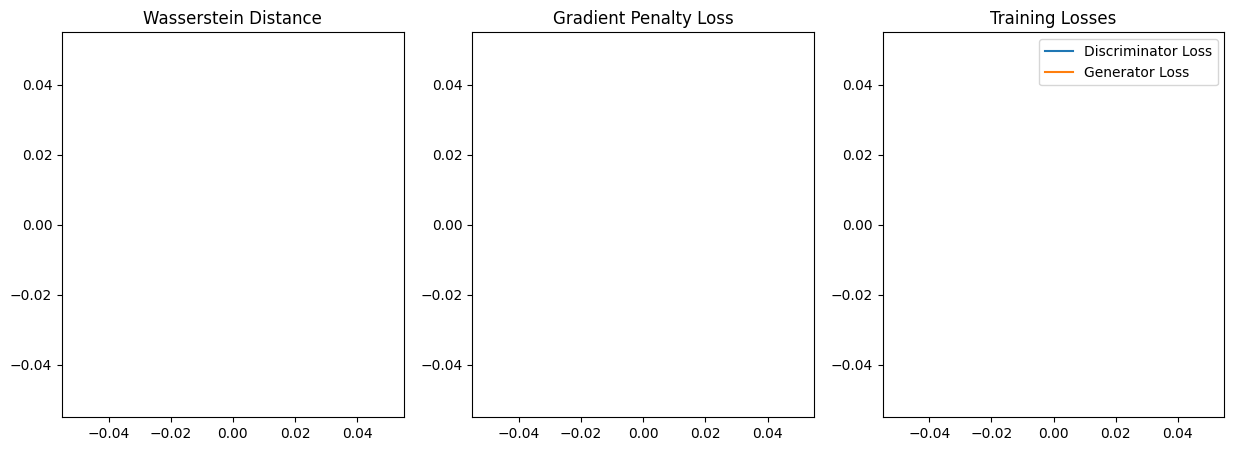

In [87]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(wass_dist)
plt.title('Wasserstein Distance')

plt.subplot(1, 3, 2)
plt.plot(gp_losses)
plt.title('Gradient Penalty Loss')

plt.subplot(1, 3, 3)
plt.plot(disc_losses, label='Discriminator Loss')
plt.plot(gen_losses, label='Generator Loss')
plt.legend()
plt.title('Training Losses')

plt.savefig('wgan_gp_training_curves.png')
plt.show()

# Create a 10x10 grid of created photos and display it.

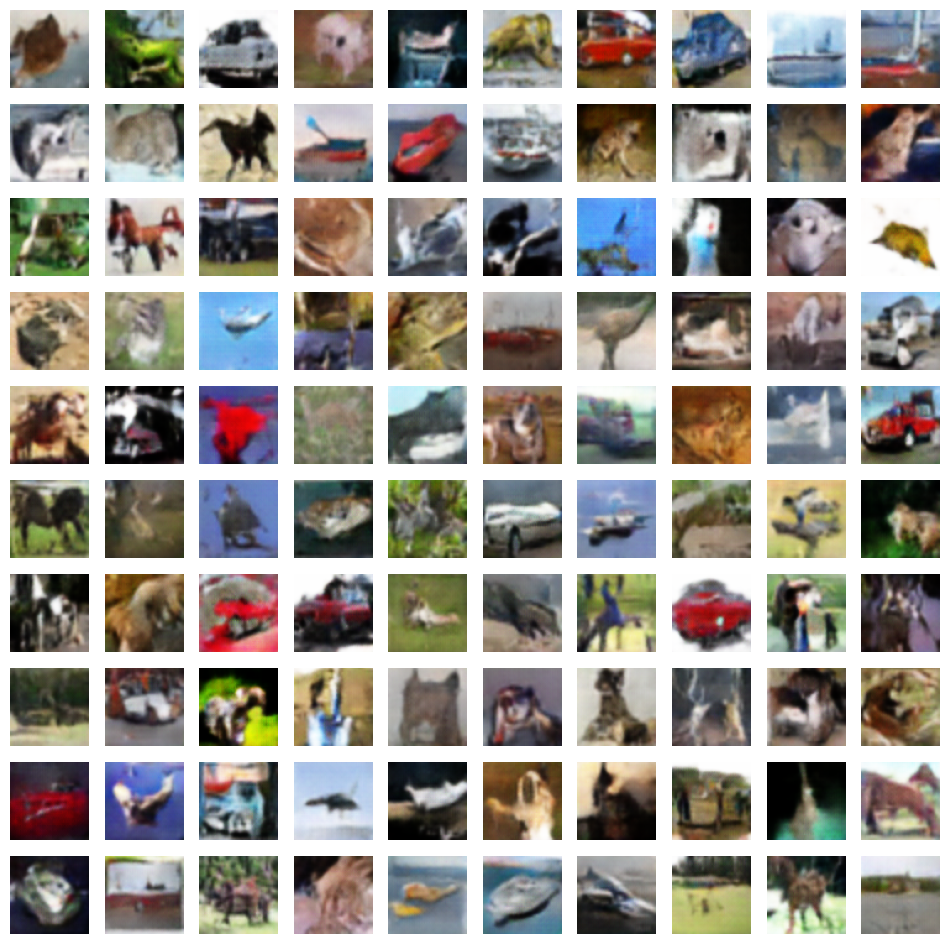

In [88]:
gen.eval()
with torch.no_grad():
    z = torch.randn(100, Z_DIM, 1, 1).to(device)
    samples = gen(z).cpu()

    # Denormalize images from [-1,1] to [0,1]
    samples = (samples + 1) / 2
    samples = samples.clamp(0, 1)

    plt.figure(figsize=(12, 12))
    for i in range(100):
        plt.subplot(10, 10, i+1)
        plt.imshow(samples[i].permute(1, 2, 0))
        plt.axis('off')
    plt.savefig('wgan_gp_final_samples.png')
    plt.show()

# Split Classifier



In [89]:
class SplitCIFARModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.client = nn.Sequential(  # Mc
            nn.Conv2d(3, 64, 3, padding=1),  # layer1
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),  # layer2
            nn.ReLU(),
        )
        self.server = nn.Sequential(  # Ms
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        z_q = self.client(x)  # leak this
        out = self.server(z_q)
        return z_q, out

In [90]:
# === Train SplitCIFARModel (Client + Server) ===

model = SplitCIFARModel().to(device)

model_path = "split_cifar_model.pth"

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print(f"Loaded model from {model_path}")
else:
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 200  # adjust as needed

  for epoch in range(num_epochs):
      progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

      model.train()
      running_loss = 0.0

      for i, (inputs, labels) in progress_bar:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()
          z_q, outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward(retain_graph=True)
          optimizer.step()

          running_loss += loss.item()

      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

# Save models
torch.save(model.state_dict(), model_path)


Loaded model from split_cifar_model.pth


In [91]:
# === Evaluate SplitCIFARModel on Test Set ===

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        _, outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 64.93%


In [92]:
# Assume G is your trained WGAN generator, and client_encoder is M_c

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
client_encoder = SplitCIFARModel().to(device)
client_encoder.eval()

# Use one sample image from CIFAR-10 as the private image
sample, _ = next(iter(test_loader))  # Use test_loader from earlier setup
sample = sample.to(device)[:1]  # take a single image

with torch.no_grad():
    z_q, _ = client_encoder(sample)

# Latent search setup
z_dim = 100  # match your WGAN z-dim
z = torch.randn((1, z_dim, 1, 1), requires_grad=True, device=device)
optimizer = torch.optim.Adam([z], lr=1e-2)
lambda_reg = 1e-2
criterion = nn.MSELoss()

for step in range(5000):
    G_z = gen(z)  # gen = your trained WGAN generator
    Mc_Gz, _ = client_encoder(G_z)

    loss = criterion(Mc_Gz.view(Mc_Gz.size(0), -1), z_q.detach().view(z_q.size(0), -1)) + lambda_reg * torch.norm(z)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    if step % 1000 == 0:
        print(f"Step {step}, Loss: {loss.item():.4f}")

Step 0, Loss: 0.1131
Step 1000, Loss: 0.0043
Step 2000, Loss: 0.0043
Step 3000, Loss: 0.0043
Step 4000, Loss: 0.0043


# Image Reconstruction

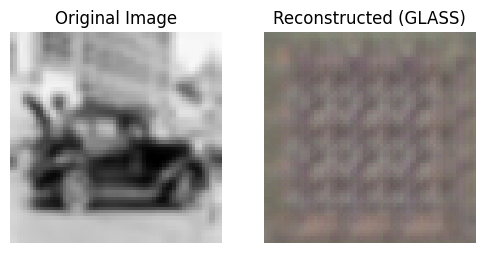

In [93]:
with torch.no_grad():
    recon_img = gen(z).detach().cpu().squeeze().permute(1, 2, 0)
    orig_img = sample.detach().cpu().squeeze().permute(1, 2, 0)

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow((orig_img + 1) / 2)
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow((recon_img + 1) / 2)
axs[1].set_title("Reconstructed (GLASS)")
axs[1].axis("off")

plt.show()

In [94]:
from torchvision.models import resnet18

# Pretrained ResNet18 as feature extractor for DISCO
resnet_feat = resnet18(pretrained=True).to(device)
resnet_feat.eval()

# Use all layers except the final classifier layer
phi = nn.Sequential(*list(resnet_feat.children())[:-2])

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Defense Analysis (DISCO)

In [95]:
enable_disco = True  # Toggle for DISCO
lambda_sem = 1.0     # Weight for semantic consistency
lambda_reg = 1e-2    # L2 regularization on z

# Assume X_priv is the real image used to produce z_q
X_priv = sample  # reused from earlier

# Extract semantic features from X_priv
with torch.no_grad():
    phi_X = phi(X_priv).detach()

# Optimize latent z
z = torch.randn((1, z_dim, 1, 1), requires_grad=True, device=device)
optimizer = torch.optim.Adam([z], lr=1e-2)
criterion_mse = nn.MSELoss()

for step in range(5000):
    G_z = gen(z)
    Mc_Gz = client_encoder(G_z)

    # loss = criterion(Mc_Gz[0].view(Mc_Gz[0].size(0), -1), z_q[0].detach().view(z_q[0].size(0), -1))
    loss = criterion(Mc_Gz[0].view(1, -1), z_q[0].view(1, -1))

    if enable_disco:
        phi_Gz = phi(G_z)
        semantic_loss = criterion_mse(phi_Gz, phi_X)
        loss += lambda_sem * semantic_loss

    loss += lambda_reg * torch.norm(z)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 1000 == 0:
        print(f"Step {step}, Total Loss: {loss.item():.4f}")

Step 0, Total Loss: 5.5823
Step 1000, Total Loss: 0.4090
Step 2000, Total Loss: 0.2985
Step 3000, Total Loss: 0.2349
Step 4000, Total Loss: 0.2264


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
SSIM Score: -0.061834592
MSE Score: 0.6389925479888916
PSNR Score: 1.9450419658735463
LPIPS Score: 0.49468234181404114


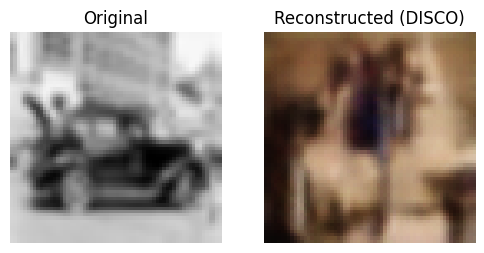

In [96]:
# Load LPIPS metric (AlexNet-based)
lpips_metric = lpips.LPIPS(net='alex').to(device)

with torch.no_grad():
    recon_img = gen(z).detach().cpu().squeeze().permute(1, 2, 0)
    orig_img = X_priv.detach().cpu().squeeze().permute(1, 2, 0)

    recon_img_np = recon_img.numpy()
    orig_img_np = orig_img.numpy()

# SSIM
ssim_score = ssim(orig_img_np, recon_img_np, data_range=1, win_size=3, channel_axis=2)
print("SSIM Score:", ssim_score)

# Reshape the images to 2D arrays before calculating MSE
orig_img_np_flat = orig_img_np.reshape(-1, 3)  # Reshape to (num_pixels, num_channels)
recon_img_np_flat = recon_img_np.reshape(-1, 3)

# Calculate the MSE
mse_score = mse(orig_img_np_flat, recon_img_np_flat)
print("MSE Score:", mse_score)

# PSNR
psnr_score = psnr(orig_img_np, recon_img_np, data_range=1)
print("PSNR Score:", psnr_score)

# LPIPS
lpips_score = lpips_metric(
    G_z.clamp(-1, 1),  # recon image
    X_priv,            # original image
).item()
print("LPIPS Score:", lpips_score)

# Visual comparison
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow((orig_img_np + 1) / 2)
axs[0].set_title("Original")
axs[0].axis("off")

axs[1].imshow((recon_img_np + 1) / 2)
axs[1].set_title("Reconstructed (DISCO)" if enable_disco else "Reconstructed (No DISCO)")
axs[1].axis("off")
plt.show()

In [97]:
class InverseNet(nn.Module):
    def __init__(self, z_dim=Z_DIM, img_channels=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Linear(512, z_dim)
        )

    def forward(self, x):
        return self.net(x)

In [98]:
def likelihood_maximization(gen, real_image, z_dim=Z_DIM, steps=500, lr=0.01):
    z = torch.randn((1, z_dim, 1, 1), requires_grad=True, device=device)
    optimizer = torch.optim.Adam([z], lr=lr)
    loss_fn = nn.MSELoss()

    for _ in range(steps):
        optimizer.zero_grad()
        fake_image = gen(z)
        loss = loss_fn(fake_image, real_image)
        loss.backward()
        optimizer.step()

    return gen(z).detach()

In [99]:
def rmle(gen, real_image, z_dim=Z_DIM, steps=500, lr=0.01, reg_lambda=0.1):
    z = torch.randn((1, z_dim, 1, 1), requires_grad=True, device=device)
    optimizer = torch.optim.Adam([z], lr=lr)
    loss_fn = nn.MSELoss()

    for _ in range(steps):
        optimizer.zero_grad()
        fake_image = gen(z)
        mse_loss = loss_fn(fake_image, real_image)
        reg_loss = reg_lambda * (z ** 2).mean()
        total_loss = mse_loss + reg_loss
        total_loss.backward()
        optimizer.step()

    return gen(z).detach()


In [100]:
def inverse_reconstruction(gen, inverse_net, real_image):
    z_pred = inverse_net(real_image)
    z_pred = z_pred.view(-1, Z_DIM, 1, 1)
    fake_image = gen(z_pred)
    return fake_image.detach()


In [101]:
# Train the Inverse Network after Generator is trained
inverse_net = InverseNet().to(device)

inverse_net_path = "inverse_net.pth"

if os.path.exists(inverse_net_path):
    inverse_net.load_state_dict(torch.load(inverse_net_path))
    print(f"Loaded inverse network from {inverse_net_path}")
else:
  optimizer_inv = torch.optim.Adam(inverse_net.parameters(), lr=1e-4)
  loss_fn = nn.MSELoss()

  EPOCHS_INV = 50
  for epoch in range(EPOCHS_INV):
      total_loss = 0.0
      for real_images, _ in train_loader:
          real_images = real_images.to(device)

          optimizer_inv.zero_grad()
          z_pred = inverse_net(real_images)
          z_pred = z_pred.view(-1, Z_DIM, 1, 1)

          reconstructed_images = gen(z_pred)
          loss = loss_fn(reconstructed_images, real_images)
          loss.backward()
          optimizer_inv.step()

          total_loss += loss.item()

      print(f"Inverse Net Epoch [{epoch+1}/{EPOCHS_INV}] Loss: {total_loss/len(train_loader):.4f}")

# Save model
torch.save(inverse_net.state_dict(), inverse_net_path)

Loaded inverse network from inverse_net.pth


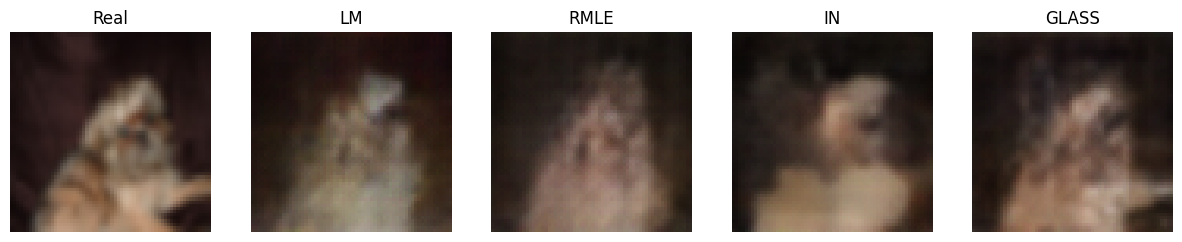

In [102]:
# Example Reconstruction on a Sample Image
import matplotlib.pyplot as plt

def plot_images(images, titles=None):
    fig, axs = plt.subplots(1, len(images), figsize=(15,5))
    for i, img in enumerate(images):
        img = img.detach().cpu().numpy()
        img = img.transpose(1, 2, 0)
        axs[i].imshow((img * 0.5) + 0.5)  # Unnormalize
        axs[i].axis('off')
        if titles:
            axs[i].set_title(titles[i])
    plt.show()

# Pick a sample real image
sample_real_image, _ = next(iter(train_loader))
sample_real_image = sample_real_image[0].unsqueeze(0).to(device)

with torch.no_grad():
    z_q, _ = client_encoder(sample_real_image)

# Latent search setup
z_dim = 100  # match your WGAN z-dim
z = torch.randn((1, z_dim, 1, 1), requires_grad=True, device=device)
optimizer = torch.optim.Adam([z], lr=1e-2)
lambda_reg = 1e-4
criterion = nn.MSELoss()

for step in range(100000):
    G_z = gen(z)  # gen = your trained WGAN generator
    Mc_Gz, _ = client_encoder(G_z)

    loss = criterion(Mc_Gz.view(Mc_Gz.size(0), -1), z_q.detach().view(z_q.size(0), -1)) + lambda_reg * torch.norm(z)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

glass_recon = gen(z).detach().cpu()
lm_recon = likelihood_maximization(gen, sample_real_image)
rmle_recon = rmle(gen, sample_real_image)
in_recon = inverse_reconstruction(gen, inverse_net, sample_real_image)

plot_images([
    sample_real_image.squeeze(),
    lm_recon.squeeze(),
    rmle_recon.squeeze(),
    in_recon.squeeze(),
    glass_recon.squeeze()
], titles=["Real", "LM", "RMLE", "IN", "GLASS"])

# Lpips and Psnr scores

In [119]:
psnr_list_disco = []
psnr_list_glass = []
psnr_list_rmle = []
psnr_list_lm = []
psnr_list_in = []

lpips_list_disco = []
lpips_list_glass = []
lpips_list_rmle = []
lpips_list_lm = []
lpips_list_in = []

ssim_list_disco = []
ssim_list_glass = []
ssim_list_rmle = []
ssim_list_lm = []
ssim_list_in = []

mse_list_disco = []
mse_list_glass = []
mse_list_rmle = []
mse_list_lm = []
mse_list_in = []

In [ ]:
import torch.nn.functional as F

# Setup LPIPS
lpips_metric = lpips.LPIPS(net='alex').to(device)

# Evaluate on test samples
client_encoder.eval()
gen.eval()
num_samples = 100
counter = 0

# For Confusion Matrix
y_true = []
y_pred_glass = []
y_pred_disco = []
y_pred_lm = []
y_pred_rmle = []
y_pred_in = []

for batch_idx, (inputs, labels) in enumerate(test_loader):  # Access labels here
    inputs = inputs.to(device)
    labels = labels.to(device)  # Move labels to device
    for idx, sample in enumerate(inputs):
        if counter >= num_samples:
            break
        X_priv = sample.unsqueeze(0)
        with torch.no_grad():
            z_q = client_encoder(X_priv)
            phi_X = phi(X_priv).detach()

        sample_real = sample.unsqueeze(0).to(device)

        lm_recon = likelihood_maximization(gen, sample_real)
        rmle_recon = rmle(gen, sample_real)
        in_recon = inverse_reconstruction(gen, inverse_net, sample_real)

        for enable_disco in [False, True]:
            z = torch.randn((1, z_dim, 1, 1), requires_grad=True, device=device)
            optimizer = torch.optim.Adam([z], lr=1e-2)

            for step in range(100000):
                G_z = gen(z)
                Mc_Gz, _ = model(G_z)
                loss = F.mse_loss(Mc_Gz[0], z_q[0].detach())
                if enable_disco:
                    phi_Gz = phi(G_z)
                    loss += lambda_sem * F.mse_loss(phi_Gz, phi_X)
                loss += lambda_reg * torch.norm(z)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            with torch.no_grad():
                recon_img = G_z.detach().cpu()
                orig_img = X_priv.cpu()

                recon_img_np = recon_img.squeeze().permute(1, 2, 0).numpy()
                orig_img_np = orig_img.squeeze().permute(1, 2, 0).numpy()

                # SSIM
                ssim_score = ssim(orig_img_np, recon_img_np, data_range=1, win_size=3, channel_axis=2)

                # Reshape for MSE
                orig_img_np_flat = orig_img_np.reshape(-1, 3)
                recon_img_np_flat = recon_img_np.reshape(-1, 3)

                # Calculate the MSE
                mse_score = mse(orig_img_np_flat, recon_img_np_flat)

                # PSNR
                psnr_score = psnr(orig_img_np, recon_img_np, data_range=1)

                # LPIPS
                lpips_score = lpips_metric(G_z.clamp(-1, 1), X_priv).item()

            if enable_disco:
                psnr_list_disco.append(psnr_score)
                lpips_list_disco.append(lpips_score)
                ssim_list_disco.append(ssim_score)
                mse_list_disco.append(mse_score)
            else:
                psnr_list_glass.append(psnr_score)
                lpips_list_glass.append(lpips_score)
                ssim_list_glass.append(ssim_score)
                mse_list_glass.append(mse_score)

            with torch.no_grad():
                # Predict using your trained CNN model
                _, pred_glass_tensor = model(recon_img.to(device).clamp(-1, 1))
                pred_glass = pred_glass_tensor.argmax(dim=1).item()

                _, pred_lm_tensor = model(lm_recon.clamp(-1, 1))
                pred_lm = pred_lm_tensor.argmax(dim=1).item()

                _, pred_rmle_tensor = model(rmle_recon.clamp(-1, 1))
                pred_rmle = pred_rmle_tensor.argmax(dim=1).item()

                _, pred_in_tensor = model(in_recon.clamp(-1, 1))
                pred_in = pred_in_tensor.argmax(dim=1).item()

                # Save ground-truth label
                true_label = labels[idx].item() # Access label using idx from inner loop

                y_true.append(true_label)
                y_pred_glass.append(pred_glass)
                y_pred_lm.append(pred_lm)
                y_pred_rmle.append(pred_rmle)
                y_pred_in.append(pred_in)

                if enable_disco:
                    y_pred_disco.append(pred_glass)

            # SSIM
            ssim_socre_rmle = ssim(orig_img_np, rmle_recon.cpu().squeeze().permute(1, 2, 0).numpy(), data_range=1, win_size=3, channel_axis=2)
            ssim_list_rmle.append(ssim_socre_rmle)

            ssim_socre_lm = ssim(orig_img_np, lm_recon.cpu().squeeze().permute(1, 2, 0).numpy(), data_range=1, win_size=3, channel_axis=2)
            ssim_list_lm.append(ssim_socre_lm)

            ssim_socre_in = ssim(orig_img_np, in_recon.cpu().squeeze().permute(1, 2, 0).numpy(), data_range=1, win_size=3, channel_axis=2)
            ssim_list_in.append(ssim_socre_in)

            # MSE
            mse_score_rmle = mse(orig_img_np_flat, rmle_recon.cpu().squeeze().permute(1, 2, 0).numpy().reshape(-1, 3))
            mse_list_rmle.append(mse_score_rmle)

            mse_score_lm = mse(orig_img_np_flat, lm_recon.cpu().squeeze().permute(1, 2, 0).numpy().reshape(-1, 3))
            mse_list_lm.append(mse_score_lm)

            mse_score_in = mse(orig_img_np_flat, in_recon.cpu().squeeze().permute(1, 2, 0).numpy().reshape(-1, 3))
            mse_list_in.append(mse_score_in)

            # PSNR
            psnr_score_rmle = psnr(orig_img_np, rmle_recon.cpu().squeeze().permute(1, 2, 0).numpy(), data_range=1)
            psnr_list_rmle.append(psnr_score_rmle)

            psnr_score_lm = psnr(orig_img_np, lm_recon.cpu().squeeze().permute(1, 2, 0).numpy(), data_range=1)
            psnr_list_lm.append(psnr_score_lm)

            psnr_score_in = psnr(orig_img_np, in_recon.cpu().squeeze().permute(1, 2, 0).numpy(), data_range=1)
            psnr_list_in.append(psnr_score_in)  # Append psnr_score_in here

            # LPIPS
            lpips_score_rmle = lpips_metric(rmle_recon.clamp(-1, 1), X_priv).item()
            lpips_list_rmle.append(lpips_score_rmle)

            lpips_score_lm = lpips_metric(lm_recon.clamp(-1, 1), X_priv).item()
            lpips_list_lm.append(lpips_score_lm)

            lpips_score_in = lpips_metric(in_recon.clamp(-1, 1), X_priv).item()
            lpips_list_in.append(lpips_score_in)

        counter += 1

print(f"Evaluation completed for {num_samples} samples.")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


<ipython-input-120-e16c86d9da17>:44: UserWarning: Using a target size (torch.Size([1, 128, 64, 64])) that is different to the input size (torch.Size([128, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(Mc_Gz[0], z_q[0].detach())
<ipython-input-120-e16c86d9da17>:44: UserWarning: Using a target size (torch.Size([1, 128, 64, 64])) that is different to the input size (torch.Size([128, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(Mc_Gz[0], z_q[0].detach())
<ipython-input-120-e16c86d9da17>:44: UserWarning: Using a target size (torch.Size([1, 128, 64, 64])) that is different to the input size (torch.Size([128, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(Mc_Gz[0], z_q[0].detach())
<ipython-input-120-e16c86d9da17>:44: UserWarning: Us

# Plotting graphs

In [ ]:
methods = ["GLASS", "GLASS + DISCO"]
avg_psnr_glass = sum(psnr_list_glass) / len(psnr_list_glass)
avg_psnr_disco = sum(psnr_list_disco) / len(psnr_list_disco)
avg_lpips_glass = sum(lpips_list_glass) / len(lpips_list_glass)
avg_lpips_disco = sum(lpips_list_disco) / len(lpips_list_disco)

# Bar Plots
plt.bar(methods, [avg_psnr_glass, avg_psnr_disco])
plt.title("Average PSNR Comparison")
plt.ylabel("PSNR (dB)")
plt.show()

plt.bar(methods, [avg_lpips_glass, avg_lpips_disco])
plt.title("Average LPIPS Comparison")
plt.ylabel("LPIPS (lower is better)")
plt.show()

# Box Plots
plt.boxplot([psnr_list_glass, psnr_list_disco], labels=methods)
plt.title("PSNR Distribution")
plt.ylabel("PSNR")
plt.show()

# Scatter Plot
plt.scatter(psnr_list_glass, psnr_list_disco)
plt.plot([min(psnr_list_glass), max(psnr_list_glass)],
         [min(psnr_list_glass), max(psnr_list_glass)], 'r--')
plt.xlabel("PSNR without DISCO")
plt.ylabel("PSNR with DISCO")
plt.title("Sample-wise PSNR Comparison")
plt.show()

# Histogram
plt.hist(psnr_list_disco, bins=10, alpha=0.5, label='DISCO')
plt.hist(psnr_list_glass, bins=10, alpha=0.5, label='No DISCO')
plt.legend()
plt.title("Histogram of PSNR Scores")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Compute confusion matrices
cm_glass = confusion_matrix(y_true, y_pred_glass)
cm_lm = confusion_matrix(y_true, y_pred_lm)
cm_rmle = confusion_matrix(y_true, y_pred_rmle)
cm_in = confusion_matrix(y_true, y_pred_in)

# Plot confusion matrices
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
ConfusionMatrixDisplay(cm_glass).plot(ax=plt.gca(), cmap='Blues')
plt.title("GLASS Reconstruction")

plt.subplot(2, 2, 2)
ConfusionMatrixDisplay(cm_lm).plot(ax=plt.gca(), cmap='Greens')
plt.title("LM Reconstruction")

plt.subplot(2, 2, 3)
ConfusionMatrixDisplay(cm_rmle).plot(ax=plt.gca(), cmap='Purples')
plt.title("RMLE Reconstruction")

plt.subplot(2, 2, 4)
ConfusionMatrixDisplay(cm_in).plot(ax=plt.gca(), cmap='Oranges')
plt.title("IN Reconstruction")

plt.tight_layout()
plt.show()

# Compute accuracies
acc_glass = accuracy_score(y_true, y_pred_glass)
acc_lm = accuracy_score(y_true, y_pred_lm)
acc_rmle = accuracy_score(y_true, y_pred_rmle)
acc_in = accuracy_score(y_true, y_pred_in)

print("=== Classification Accuracy ===")
print(f"GLASS: {acc_glass*100:.2f}%")
print(f"LM:    {acc_lm*100:.2f}%")
print(f"RMLE:  {acc_rmle*100:.2f}%")
print(f"IN:    {acc_in*100:.2f}%")